## Problem Statement

The challenge is to develop a chatbot that accurately replicates an individual’s unique chat style based on their WhatsApp messages.

In [1]:
import re
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

## Data Acquisition

- **Source:** WhatsApp chat logs.
- **Key Features (Input):**
  - Message content
  - Timestamps
  - Sender info
  - Conversation context
- **Output Needed:** Responses that reflect the target person’s communication style.

In [2]:
datetime_formats = ["%d/%m/%y, %H:%M", "%m/%d/%y, %H:%M", "%d/%m/%y %H:%M:%S"]
stop_words = ['created group', 'Messages and calls are end-to-end encrypted', 'is a contact', 'deleted this message' '未接语音通话', '消息和通话都进行端到端加密', '语音通话', '这条消息已被删除']
DIRECTORY = './data/'
FILES = [f for f in os.listdir(DIRECTORY) if f.endswith('.txt')]
print(FILES)

def get_datapoint(line: str):
    match = re.search(r'\[?(\d{2}\/\d{2}\/\d{2} \d{2}:\d{2}:\d{2}|\d{1,2}\/\d{1,2}\/\d{2}, \d{2}:\d{2})\]? (?:- )?(.*?): ?(.+)', line)
    if match is None:
      return line.strip(),
    date, author, message = match.groups()
    return date, author, message


def get_datetime_format(filename):
    formats = ["%d/%m/%y, %H:%M", "%m/%d/%y, %H:%M", "%d/%m/%y %H:%M:%S"]
    with open(f"{DIRECTORY}{filename}", encoding='utf-8') as fp:
        lines = fp.readlines()
        for line in lines:
            date = re.search(r'^\[?(.*?)(?:\]| -)', line)
            if date is None:
                continue
            for i, format in enumerate(formats):
                try:
                    datetime.strptime(date.group(1), format)
                except ValueError:
                    formats.pop(i)
            if len(formats) == 1:
              break
        return formats[0]


def load(file):
  res = []
  with open(f"{DIRECTORY}{file}", encoding="utf-8") as fp:
    lines = fp.readlines()
    counter = 0
    DATETIME_FORMAT = get_datetime_format(file)
    date, time, author = None, None, None
    message_buffer = []

    for line in lines[1:]:
      line = line.replace(u'\u200e', '')
      message_data = get_datapoint(line)

      if len(message_data) == 1:
        if any(i in line for i in stop_words):
          continue
        message_buffer.append(message_data[0])
      else:
        if len(message_buffer) > 0:
          date_parsed = datetime.strptime(date, DATETIME_FORMAT)
          res.append([date_parsed, author, ' '.join(message_buffer)])
          counter += 1
        message_buffer.clear()
        date, author, message = get_datapoint(line)
        try:
          date_parsed = datetime.strptime(date, DATETIME_FORMAT)
          if date_parsed:
            message_buffer.append(message)
        except ValueError:
          pass

  print(f"Loaded {file} with {counter} datapoints")
  return res

['2.txt', '1.txt']


In [3]:
data = []
for f in FILES:
  data.extend(load(f))
print(len(data), "datapoints in total.")

Loaded 2.txt with 52052 datapoints
Loaded 1.txt with 16246 datapoints
68298 datapoints in total.


In [4]:
df = pd.DataFrame(data, columns=["Date", 'Author', 'Message'])
prev_datetime = df["Date"].shift(periods=1)
df["time_delta"] = (df["Date"] - prev_datetime).dt.total_seconds()
df = df.sort_values(by="Date").reset_index(drop=True)

authors = list(df.Author.unique())
author_mapping = {author: chr(97 + i) for i, author in enumerate(authors)}
df['Author'] = df['Author'].map(author_mapping)

In [ ]:
df.head()

## Exploratory Analysis

Here we analyze the number of messages per day

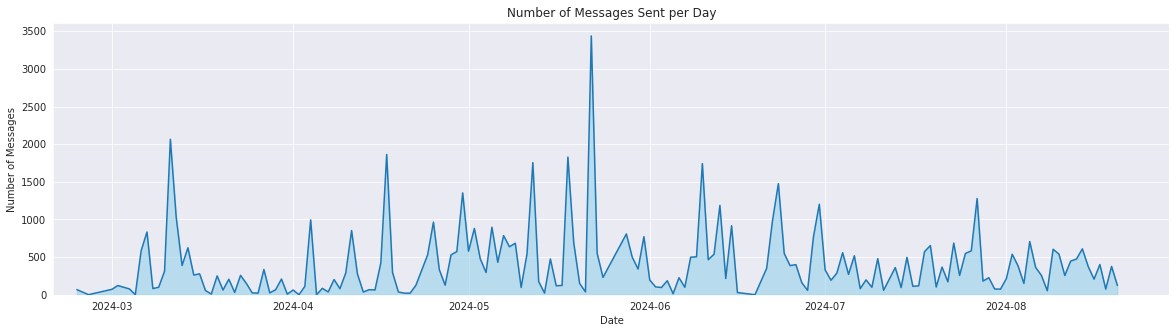

In [6]:
plt.figure(figsize=(20, 5))

grouped = df.groupby(df['Date'].dt.date).agg({'Message': 'count'}).reset_index()
sns.lineplot(data=grouped, x='Date', y='Message')
plt.fill_between(grouped['Date'], grouped['Message'], color='skyblue', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.title('Number of Messages Sent per Day')
plt.xlim(pd.Timestamp('2024-02-20'))
plt.ylim(0)
plt.grid(True)
plt.show()

In [7]:
resampled = df.set_index('Date').resample('D').count().fillna(0)
max_date = resampled['Message'].idxmax()
max_messages = resampled.loc[max_date, 'Message']
avg_messages = resampled['Message'].mean()

print(f"Most messages sent on {max_date.strftime('%Y-%m-%d')} at {max_messages} messages")
print(f"On average, {avg_messages} messages are sent per day")

Most messages sent on 2024-05-22 at 3437 messages
On average, 381.55307262569835 messages are sent per day


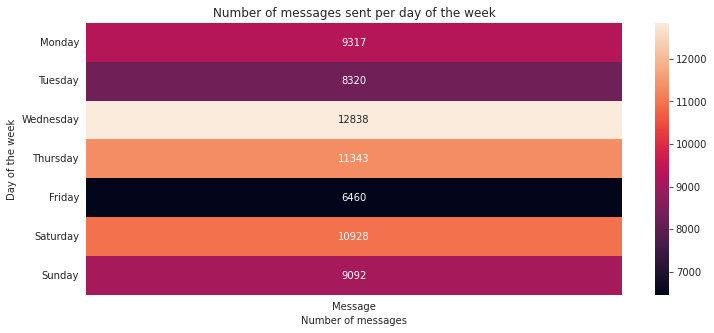

In [8]:
df['Day'] = df['Date'].dt.day_name()

pivot = df.pivot_table(index='Day', values='Message', aggfunc='count')
pivot = pivot.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 5))
sns.heatmap(pivot, annot=True, fmt='d')
plt.title('Number of messages sent per day of the week')
plt.ylabel('Day of the week')
plt.xlabel('Number of messages')
plt.show()

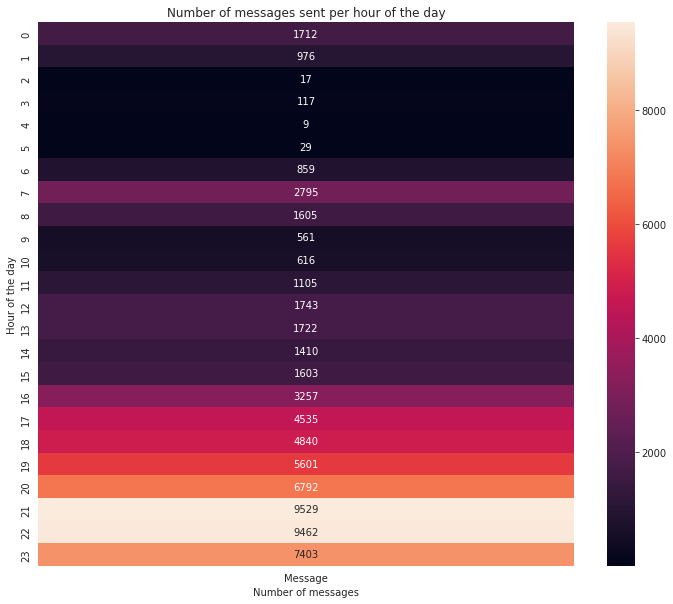

In [9]:
df['Hour'] = df["Date"].dt.hour
pivot = df.pivot_table(index='Hour', values='Message', aggfunc='count')

plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, fmt='d')
plt.title('Number of messages sent per hour of the day')
plt.ylabel('Hour of the day')
plt.xlabel('Number of messages')
plt.show()

## Data Cleaning

a) Removed specific text patterns (e.g., "<Media omitted>", URLs)

b) Filtered out excessively long messages (above 99th percentile)

c) Merged messages from the same author within short time frames

d) Standardized punctuation and removed repetitive characters

In [10]:
texts_to_remove = ['<Media omitted>', '<This message was edited>', 'https?://\S+', '[\u4e00-\u9fff]+', '13135550002']
df = df[~df['Message'].str.contains('|'.join(texts_to_remove), regex=True)]
df = df[df['Message'].str.strip().astype(bool)]
df.reset_index(drop=True, inplace=True)
df.shape

(64063, 6)

Remove excessively long messages

In [11]:
df['Word_Count'] = df['Message'].apply(lambda x: len(x.split()))
percentile = int(df['Word_Count'].quantile(0.998))
print(f"Removing messages with more than {percentile} words")
df = df[df['Word_Count'] <= percentile]
df.shape

Removing messages with more than 32 words


(63934, 7)

Join messages sent by the same author that are sent in the same time frame together, lengthening the responses.

In [12]:
merged_messages = []
current_author = None
current_message = []
current_datetime = None
current_word_count = 0

for _, row in df.iterrows():
    author = row['Author']
    message = row['Message']
    datetime = row['Date']
    word_count = row['Word_Count']

    if author == current_author and current_word_count + word_count <= percentile:
        current_message.append(message)
        current_word_count += word_count
        current_datetime = min(current_datetime, datetime)
    else:
        if current_message:
            merged_messages.append({
                'Author': current_author,
                'Message': ' '.join(current_message),
                'Datetime': current_datetime
            })

        current_author = author
        current_message = [message]
        current_datetime = datetime
        current_word_count = word_count

if current_message:
    merged_messages.append({
        'Author': current_author,
        'Message': ' '.join(current_message),
        'Datetime': current_datetime
    })

df = pd.DataFrame(merged_messages)

In [ ]:
df.head()

Here we look at the word count distribution of the new merged messages

count    32051.000000
mean         6.425073
std          6.384671
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         32.000000
Name: Word_Count, dtype: float64


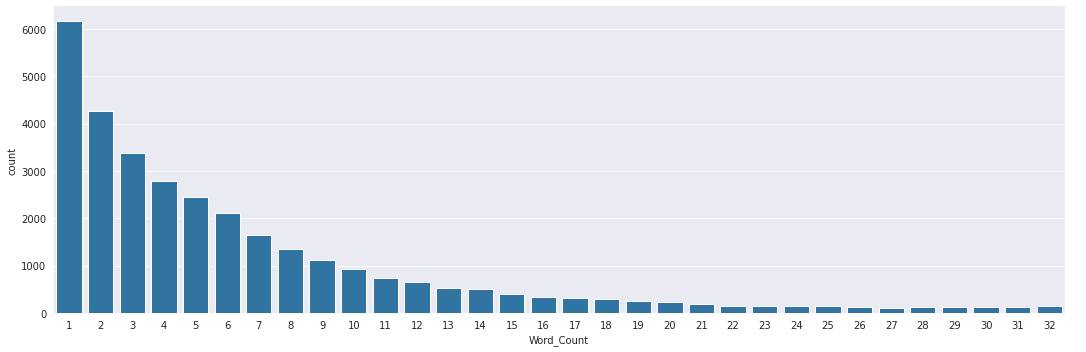

In [14]:
df['Message'] = df['Message'].apply(lambda text: re.sub(r'([^\w\s])\1+', r'\1', text))
df['Message'] = df['Message'].str.replace(r'([!?.])\1+', r'\1', regex=True)

df['Word_Count'] = df['Message'].apply(lambda x: len(x.split()))
print(df['Word_Count'].describe())
sns.catplot(x="Word_Count", data=df, kind="count", aspect=3)

Now convert the messages into conversation format. Messages are grouped by 3 min intervals.

In [17]:
def to_sharegpt_format(df):
    return [{'from': 'gpt' if row['Author'] == 'b' else 'human', 'value': row['Message']} for _, row in df.iterrows()]

df['Conversation_ID'] = (df['Datetime'].diff() > pd.Timedelta('3min')).cumsum()
conversations = [df_group for _, df_group in df.groupby('Conversation_ID')]
results = [to_sharegpt_format(convo) for convo in conversations]
results = [convo for convo in results if len(convo) > 1]
print(len(results))

1000


In [ ]:
random.sample(results, 1)

Save the preprocessed data

In [19]:
import json
with open('conversations.json', 'w+') as f:
    json.dump(results, f, indent=4)